# Capstone Project: Singapore HDB Resale Price Prediction
___

<p align = 'center'>
  <img src = "https://github.com/ElangSetiawan/sg-hdb-resale/blob/main/images/hdb_shintaro_tay_st_photo.jpg?raw=true" width = 75%>
<p/>
Source : https://www.straitstimes.com/singapore/housing/households-that-received-help-with-mortgage-payments-nearly-triple-that-of-same


**Problem Statement**

Public housing in Singapore is subsidised housing built and managed by the government under the Housing and Development Board (HDB). Most public housing in Singapore is owner-occupied. Under Singapore’s housing ownership programme, housing units are sold to applicants who meet certain income, citizenship and property ownership requirements, on a 99-year leasehold. The estate’s land and common areas continue to be owned by the government. Owner-occupied public housing can be sold to others in a resale market, subject to certain restrictions. Prices within the resale market are not regulated by the government.

Demand for resale flats since the end of the Circuit Breaker has pushed prices and sales to new highs. According to the HDB Price Index in Q2 2021, resale flat prices climbed 3% from Q1 2021, growing for the fifth consecutive quarter since Q2 2020. Prices were also 11% higher compared to a year ago. As data scientists, we want to understand the factors driving the price of resale flats as and provide predicted sale price for property portals.

**Model Explored**

|Models|Description|
|---|---|
|LinearRegression|
|XGBRegressor|


**Evaluation Metrics**

The evaluation metrics will be overfitting/underfitting of less than 2% between train and test data.

**Workflow Process**  
1. Notebook 1 of 2 : General EDA
2. Notebook 1 of 2 : EDA on Geolocation
3. Notebook 2 of 2 : Data Preprocessing
4. Notebook 2 of 2 : Feature Engineering
5. Notebook 2 of 2 : Create Model
6. Notebook 2 of 2 : Iterative Model tuning


In [ ]:
# # installing less common packages (uncomment if you do not have these installed)
# !pip install geopy
# !pip install geopandas
# !pip install featuretools
# !pip install pycaret

In [8]:
# The following code imports the standard required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *

import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.distance import geodesic
from pyproj import Geod

import folium

import json 
import requests
import time

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

from sklearn.base import BaseEstimator, TransformerMixin


import warnings
# warnings.filterwarnings('ignore')

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

# 1.0 Data Import
___
Reload the data from part 1

In [5]:
# Load the pickled dataframes. 
import pickle

print("unpickling df_info")
picklefile = open('../data/interim/df_info.pickle', 'rb') #load a file
df_info = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close()                                        #close file
print('df_info: ',df_info.shape)
print()

print("unpickling df_price")
picklefile = open('../data/interim/df_price.pickle', 'rb') #load a file
df_price = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close()                                         #close file
print('df_price: ', df_price.shape)
print()

print("unpickling df_mrt_lrt")
picklefile = open('../data/interim/df_mrt_lrt.pickle', 'rb') #load a file
df_mrt_lrt = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close()                                          #close file
print('df_mrt_lrt: ', df_mrt_lrt.shape)
print()

print("unpickling df_school")
picklefile = open('../data/interim/df_school.pickle', 'rb') #load a file
df_school = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close()                                          #close file
print('df_school: ', df_school.shape)
print()

print("unpickling df_shopping")
picklefile = open('../data/interim/df_shopping.pickle', 'rb') #load a file
df_shopping = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close()                                            #close file
print('df_shopping: ', df_shopping.shape)
print()

print("unpickling sg_districts")
picklefile = open('../data/interim/sg_districts.pickle', 'rb') #load a file
sg_districts = pickle.load(picklefile)                         #unpickle the dataframe
picklefile.close() #close file
print('sg_districts: ', sg_districts)


unpickling df_info
df_info:  (12442, 34)

unpickling df_price
df_price:  (113506, 25)

unpickling df_mrt_lrt
df_mrt_lrt:  (166, 9)

unpickling df_school
df_school:  (184, 8)

unpickling df_shopping
df_shopping:  (153, 8)

unpickling sg_districts
sg_districts:  {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 14: 3, 15: 3, 16: 3, 9: 4, 10: 4, 11: 5, 12: 5, 13: 5, 17: 6, 18: 7, 19: 7, 20: 8, 21: 8, 22: 9, 23: 9, 24: 10, 25: 10, 26: 10, 27: 10, 28: 11, 29: 11, 30: 11, 31: 12, 32: 12, 33: 12, 34: 13, 35: 13, 36: 13, 37: 13, 38: 14, 39: 14, 40: 14, 41: 14, 42: 15, 43: 15, 44: 15, 45: 15, 46: 16, 47: 16, 48: 16, 49: 17, 50: 17, 81: 17, 51: 18, 52: 18, 53: 19, 54: 19, 55: 19, 82: 19, 56: 20, 57: 20, 58: 21, 59: 21, 60: 22, 61: 22, 62: 22, 63: 22, 64: 22, 65: 23, 66: 23, 67: 23, 68: 23, 69: 24, 70: 24, 71: 24, 72: 25, 73: 25, 77: 26, 78: 26, 75: 27, 76: 27, 79: 28, 80: 28}


# 2.0 Modeling 
___

## 2.1 Setup pycaret 
The library pycaret is used for modelling

In [6]:
# Setup pycaret
random_seed = 42

# Set aside 10% of the df_price to represent new data (i.e unseen by the training)
data = df_price.sample(frac=0.9, random_state=random_seed)
data_unseen = df_price.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (102155, 25)
Unseen Data For Predictions: (11351, 25)


In [14]:
# Setup the pycaret experiment
exp_reg101 = setup(data = data, target = 'resale_price', session_id=random_seed,
                  ignore_features=['block','street_name','point','address', 'latitude', 'longitude', 'mailing_address',
                                   'price_psf','month','town','lease_commence_date','remaining_lease','postcode'],
                  categorical_features=['district']) 


,Description,Value
0,session_id,42
1,Target,resale_price
2,Original Data,"(102155, 25)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(71508, 138)"


## 2.1 Compare all models to determine base result


In [15]:
best = compare_models(exclude = ['ransac'])
# The RANSAC regression model is excluded from comparison

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,23140.7051,1037548773.3689,32206.8675,0.9587,0.0693,0.0521,34.6990
catboost,CatBoost Regressor,24146.2746,1079360778.8293,32848.0380,0.9570,0.0706,0.0542,5.5230
et,Extra Trees Regressor,24662.5136,1171186720.0435,34217.3733,0.9534,0.0739,0.0555,49.6650
xgboost,Extreme Gradient Boosting,26177.1420,1264129702.4000,35548.0387,0.9497,0.0760,0.0587,10.7910
lightgbm,Light Gradient Boosting Machine,29976.8666,1642227201.0760,40520.2103,0.9346,0.0857,0.0668,0.4850
dt,Decision Tree Regressor,30790.2685,1902196054.1036,43610.0498,0.9243,0.0944,0.0693,0.7960
knn,K Neighbors Regressor,30932.9039,2153754022.4000,46393.7152,0.9143,0.0925,0.0670,2.8300
gbr,Gradient Boosting Regressor,46573.2974,3901892492.9541,62459.8379,0.8447,0.1269,0.1027,9.2520
br,Bayesian Ridge,48864.2774,3968612965.4055,62994.0010,0.8421,0.1511,0.1139,1.1750
lr,Linear Regression,48862.9695,3968612019.2000,62993.9887,0.8421,0.1511,0.1139,1.0950


## 2.2 Choose the model to use
The above result shows that Random Forest Regressor, CatBoost Regressor and Extra Trees Regressor with default parameter performs as the top three best model based on R2 criteria.
In this project, the following models are selected:
- rf: Random Forest Regressor (best model above)
- xgboost: Extreme Gradient Boosting (familiarity as it is used in a previous project)
- lasso: LASSO Regression (discussed in GA material)

In [16]:
# List all available models in pycaret
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


## 2.2.1 Random Forest Regressor

In [20]:
# 2.2.1 Random Forest Regressor
rf_reg101 = create_model('rf', fold = 5)
print(rf_reg101)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,23627.1615,1084987590.1975,32939.1498,0.9563,0.0709,0.0531
1,23403.7558,1056232245.6437,32499.7269,0.9579,0.0703,0.0529
2,23611.9000,1084399810.1825,32930.2264,0.9563,0.0703,0.0530
3,23713.5062,1108426154.2182,33293.0346,0.9566,0.0706,0.0530
4,23388.1086,1043454889.6915,32302.5524,0.9589,0.0700,0.0528
Mean,23548.8864,1075500137.9867,32792.9380,0.9572,0.0704,0.0530
SD,129.6995,23028191.7360,351.2189,0.0010,0.0003,0.0001


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [54]:
df_predict_rf = predict_model(rf_reg101)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,67240.9597,10283130056.0720,101405.7693,0.5922,0.1945,0.1405


The Random Forest Regressor training model mean MSE is 1075500137.9867 and mean RMSE is 32792.9380. <br>
The Random Forest Regressor test model mean MSE is 10283130056.0720 and mean RMSE is 101405.7693. 	


In [30]:
MSE_diff = abs(1-(1075500137.9867/10283130056.0720))
RMSE_diff = abs(1-(32792.9380/101405.7693))


# if this is between 1-2%, then no overfitting.
print("Percentage of MSE difference:", MSE_diff*100.00, "%")
print("Percentage of RMSE difference:", RMSE_diff*100.00, "%")

#This is an overfitted model

Percentage of MSE difference: 89.54112092211032 %
Percentage of RMSE difference: 67.661664394079 %


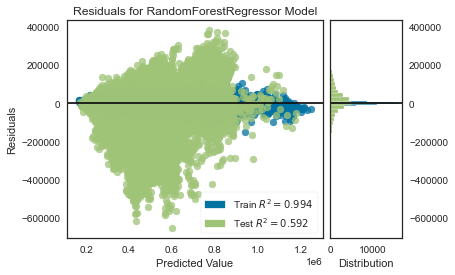

In [35]:
plot_model(rf_reg101)

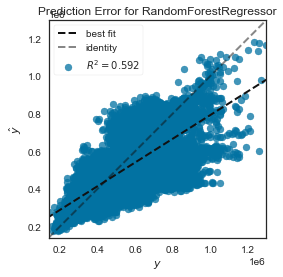

In [36]:
plot_model(rf_reg101, plot = 'error')

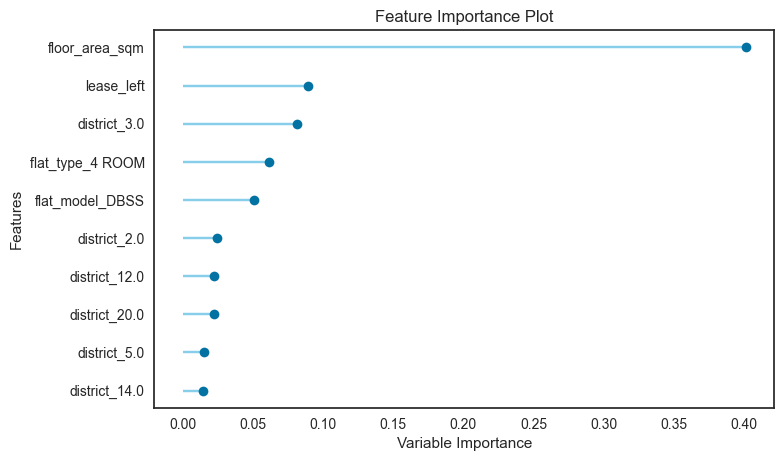

In [38]:
plot_model(rf_reg101, plot = 'feature')

## 2.2.1 Random Forest Regressor

In [27]:
# 2.2.2  Extreme Gradient Boosting
xgboost_reg101 = create_model('xgboost', fold = 5)
print(xgboost_reg101)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26080.3535,1274451968.0000,35699.4688,0.9486,0.0758,0.0581
1,25629.7109,1212567552.0000,34821.9414,0.9517,0.0751,0.0579
2,26544.9590,1312708352.0000,36231.3164,0.9471,0.0765,0.0590
3,25833.6875,1236351872.0000,35161.7969,0.9516,0.0751,0.0578
4,26415.1289,1262558208.0000,35532.4961,0.9502,0.0769,0.0596
Mean,26100.7680,1259727590.4000,35489.4039,0.9499,0.0759,0.0585
SD,343.4449,34065449.4291,479.4269,0.0018,0.0007,0.0007


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='auto',
             validate_parameters=1, verbosity=0)


In [55]:
df_predict_xg = predict_model(xgboost_reg101)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,62254.8750,7868199936.0000,88702.8750,0.6879,0.1698,0.1312


The XGBoost Regressor training model mean MSE is 1259727590.4000 and mean RMSE is 35489.4039. <br>
The XGBoost Regressor test model mean MSE is 7868199936.0000 and mean RMSE is 88702.8750. 	


In [32]:
MSE_diff = abs(1-(1259727590.4000/7868199936.0000))
RMSE_diff = abs(1-(35489.4039/88702.8750))


# if this is between 1-2%, then no overfitting.
print("Percentage of MSE difference:", MSE_diff*100.00, "%")
print("Percentage of RMSE difference:", RMSE_diff*100.00, "%")

#This is an overfitted model

Percentage of MSE difference: 83.9896342156194 %
Percentage of RMSE difference: 59.990694890103626 %


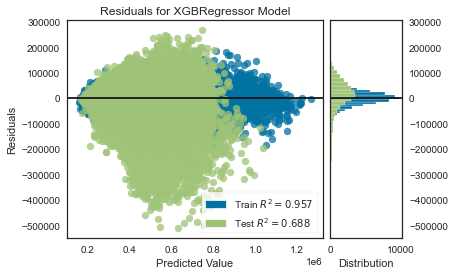

In [39]:
plot_model(xgboost_reg101)

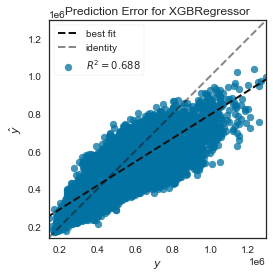

In [41]:
plot_model(xgboost_reg101, plot = 'error')

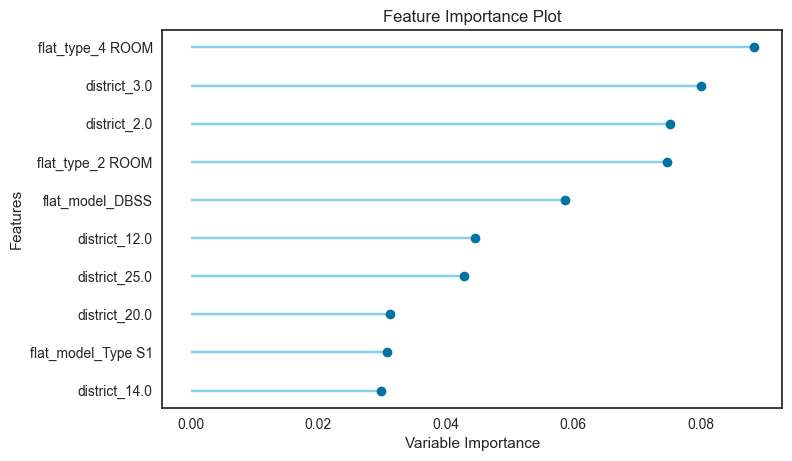

In [42]:
plot_model(xgboost_reg101, plot = 'feature')

In [22]:
# 2.2.3  LASSO Regression
lasso_reg101 = create_model('lasso', fold = 5)
print(lasso_reg101)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,48816.1680,3960630272.0000,62933.5391,0.8404,0.1514,0.1136
1,48523.9922,3898596352.0000,62438.7422,0.8447,0.1512,0.1139
2,48885.7070,3969588480.0000,63004.6719,0.8402,0.1503,0.1137
3,49536.3867,4098909952.0000,64022.7305,0.8395,0.1513,0.1146
4,48573.5625,3922862848.0000,62632.7617,0.8454,0.1514,0.1136
Mean,48867.1633,3970117580.8000,63006.4891,0.8420,0.1511,0.1139
SD,361.8763,69319636.1737,547.7372,0.0025,0.0004,0.0004


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)


The LASSO training model mean MSE is 3970117580.8000 and mean RMSE is 63006.4891.

In [56]:
df_predict_la = predict_model(lasso_reg101)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,81846.6094,11780578304.0000,108538.3828,0.5328,0.2826,0.1803


In [34]:
MSE_diff = abs(1-(3970117580.8000/11780578304.0000))
RMSE_diff = abs(1-(63006.4891/108538.3828))


# if this is between 1-2%, then no overfitting.
print("Percentage of MSE difference:", MSE_diff*100.00, "%")
print("Percentage of RMSE difference:", RMSE_diff*100.00, "%")

#This is an overfitted model

Percentage of MSE difference: 66.29946783298423 %
Percentage of RMSE difference: 41.95003880231022 %


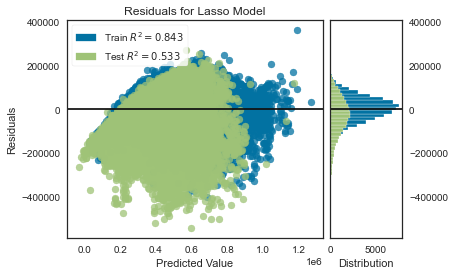

In [43]:
plot_model(lasso_reg101)

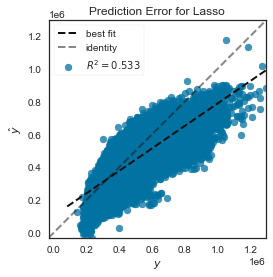

In [44]:
plot_model(lasso_reg101, plot = 'error')

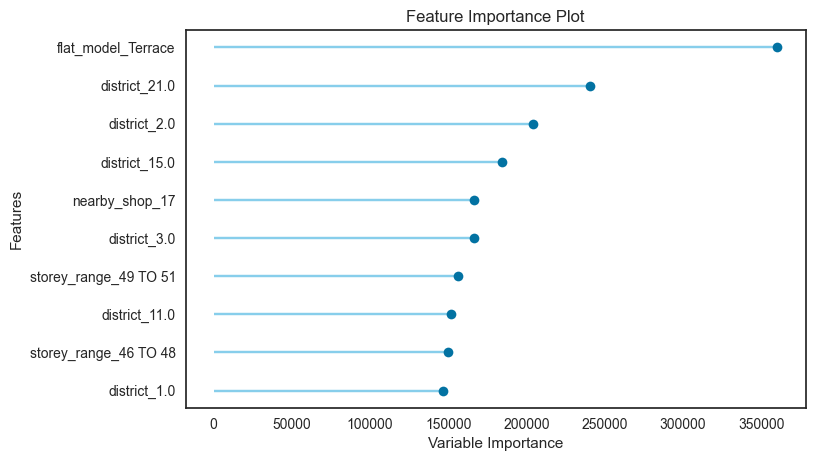

In [45]:
plot_model(lasso_reg101, plot = 'feature')

## 2.3 Tune the models 
Pycaret provides function to tune models. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. 

In [46]:
rf_params = {'bootstrap': [True, False],
             'max_depth': [10, 50, 100],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400]}
tuned_rf_reg101 = tune_model(rf_reg101, fold=5, optimize='RMSE', search_library='scikit-learn', custom_grid = rf_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27241.5707,1349287174.7024,36732.6445,0.9456,0.0784,0.0613
1,27066.5248,1340672507.0824,36615.1950,0.9466,0.0782,0.0612
2,27213.2105,1359772952.8608,36875.0994,0.9452,0.0784,0.0613
3,27393.2990,1421018976.7663,37696.4054,0.9444,0.0785,0.0610
4,27215.2809,1350432029.0503,36748.2248,0.9468,0.0786,0.0615
Mean,27225.9772,1364236728.0924,36933.5138,0.9457,0.0784,0.0612
SD,103.8674,29029228.1254,390.2366,0.0009,0.0001,0.0001


In [57]:
df_predict_rf = predict_model(tuned_rf_reg101)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,54793.4289,5653431611.0774,75189.3052,0.7758,0.1497,0.1210


In [49]:
"""
Previous results:
Percentage of MSE difference: 89.54112092211032 %
Percentage of RMSE difference: 67.661664394079 %
"""
MSE_diff = abs(1-(1364236728.0924/5653431611.0774))
RMSE_diff = abs(1-(36933.5138/75189.3052))


# if this is between 1-2%, then no overfitting.
print("Percentage of MSE difference:", MSE_diff*100.00, "%")
print("Percentage of RMSE difference:", RMSE_diff*100.00, "%")

#This is an overfitted model

Percentage of MSE difference: 75.8688735984831 %
Percentage of RMSE difference: 50.87929898838858 %


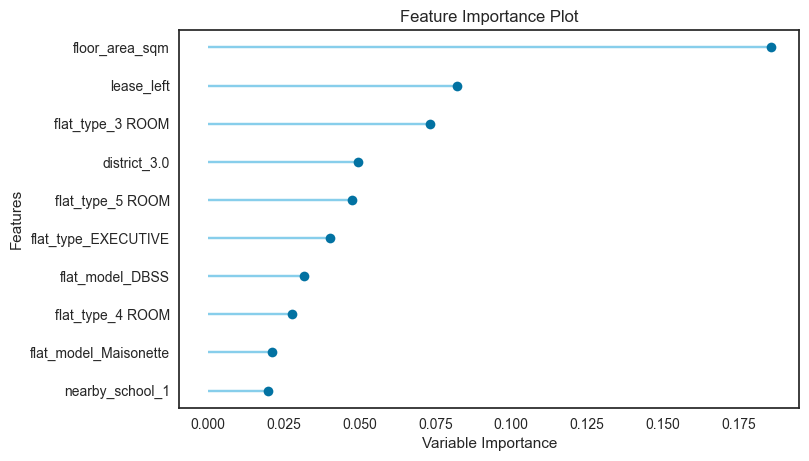

In [50]:
plot_model(tuned_rf_reg101, plot = 'feature')

In [48]:
"""
Previous hyperparameters:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
"""
print(tuned_rf_reg101)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [ ]:
tuned_xgboost_reg101 = tune_model(xgboost_reg101, fold=5, optimize='RMSE', search_library='scikit-learn')

In [ ]:
tuned_lasso_reg101 = tune_model(lasso_reg101, fold=5, optimize='RMSE', search_library='scikit-learn')